In [ ]:
import logging
import math
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt
from scipy.stats import rankdata
from sklearn.preprocessing import normalize
from math import log
from mpl_toolkits.axes_grid1 import make_axes_locatable   
import random
from mpl_toolkits.mplot3d import axes3d

from scipy.special import logit as logit


class Logger(object):
    def __init__(self, log_file_name, log_level, logger_name):
        self.__logger = logging.getLogger(logger_name)
        self.__logger.setLevel(log_level)
        file_handler = logging.FileHandler(log_file_name)
        console_handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '[%(asctime)s] - [%(filename)s line:%(lineno)d] : %(message)s')
        file_handler.setFormatter(formatter)
        console_handler.setFormatter(formatter)
        self.__logger.addHandler(file_handler)
        self.__logger.addHandler(console_handler)

    def get_log(self):
        return self.__logger


def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom
    
    
logger = Logger('C:\\Users\\bird\\Desktop\\cancer_project_github\\log.txt', log_level=logging.DEBUG, logger_name="CIFAR").get_log()

clinical_231_file = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\clinical_231_data.csv'
mRNA_231_file = 'C:\\Users\\bird\\Desktop\\cancer_project_github\\cancer_data\\data_mRNA_231_sort_with_sensitive.csv'




In [126]:
"""
load data
"""
filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_133_genes_data.csv'
# the SAMPLE_ID in the file is the corresponding SAMPLE_ID in data_mRNA_231_sort_with_sensitive
mRNA_231_df=pd.read_csv(filterd_data)

st = [str(x) for x in range(231)]

mRNA_231_df.drop_duplicates(subset=st)

mRNA_231_df = mRNA_231_df.set_index('SAMPLE_ID')
print(mRNA_231_df)
print(mRNA_231_df)


               0       1       2        3       4          5       6        7  \
SAMPLE_ID                                                                       
2          8.693  22.395  50.843   66.151  54.679  11564.212  43.055  394.181   
9          1.164  32.202  58.076   29.167  52.251   8333.306  18.559  101.457   
115        0.243   0.392   0.418  332.090   0.367      0.143   0.597    0.996   
123        0.106   0.141   0.291    0.105   0.061      3.551   0.378    0.790   
151        3.038   0.185   0.295    1.566   0.492      2.286   0.000    1.703   
...          ...     ...     ...      ...     ...        ...     ...      ...   
13580      0.060   0.547   0.186    0.305   0.052      0.010   0.398    0.159   
13683      0.027   0.053   0.028    0.134   0.243      0.000   0.188    0.123   
13749      0.000   0.006   0.007    0.000   0.009      0.014   0.037    0.000   
13940      0.016   0.044   0.032    1.883   0.007      0.000   0.000    0.022   
14119      0.006   0.021   0

(231, 133)


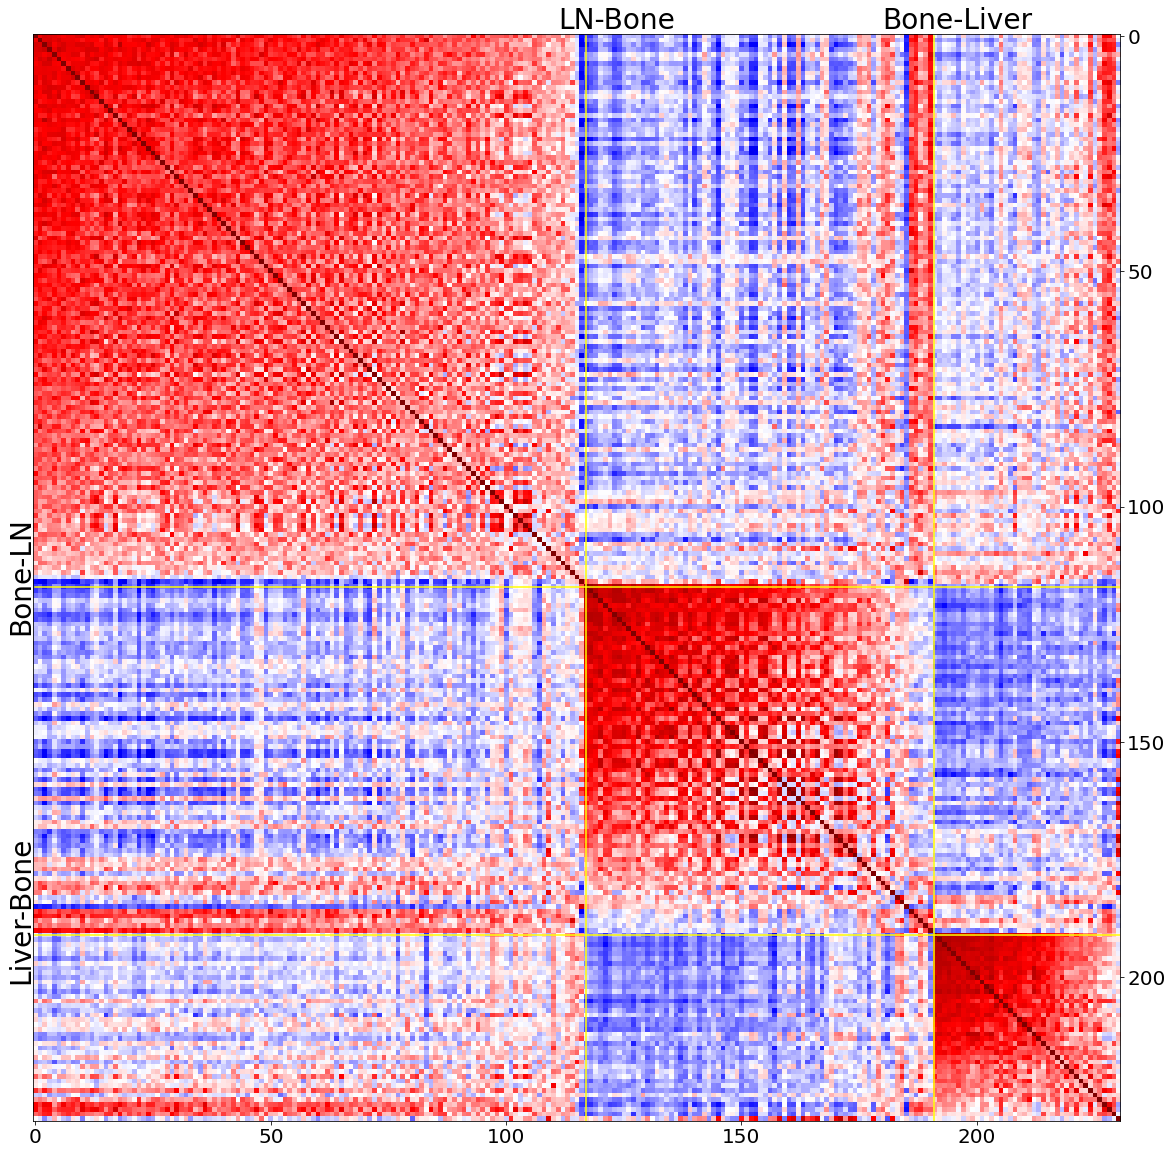

In [127]:
mRNA_231_df=pd.read_csv(filterd_data)
mRNA_231_df = mRNA_231_df.set_index('SAMPLE_ID')
patient_mRNA = []
for column in mRNA_231_df:
    #     print(mRNA_244_df[column].tolist())
    patient_mRNA.append(mRNA_231_df[column].tolist())
mRNA_np = np.asarray(patient_mRNA)



print(mRNA_np.shape)
    


sorts = {"":'0',
    "homo":'1',
    "hetero":"2"}

norms = {'': '0',
         'linear_scale_and_bin': 'A',
         'log_scale_and_bin': 'A',
         'rank_and_scale': 'B'
}

params = ['homo','mean', 'rank_and_scale', sorts, norms] # scheme = {'', 'hetero' 'homo'}, norm = {'','rank_and_scale', 'scale_and_bin_linear', 'log_scale_and_bin'}
norm = 'rank_and_scale'
# patient_np = plot_genes[i].T
#     patient_np = plot_genes[i,3].T   # uncomment this for intersect_genes only

correlation_matrix, patient_np = norm_and_sort_patients(mRNA_np, params)#hetero homo scale_and_bin rank_and_scale


plot_heatmap(correlation_matrix,params)


In [134]:
mRNA_231_df=pd.read_csv(filterd_data)
mRNA_231_df = mRNA_231_df.set_index('SAMPLE_ID')
patient_mRNA = []
for column in mRNA_231_df:
    #     print(mRNA_244_df[column].tolist())
    patient_mRNA.append(mRNA_231_df[column].tolist())
dataset = np.asarray(patient_mRNA)
print(dataset)

[[8.69300e+00 1.16400e+00 2.43000e-01 ... 0.00000e+00 1.60000e-02
  6.00000e-03]
 [2.23950e+01 3.22020e+01 3.92000e-01 ... 6.00000e-03 4.40000e-02
  2.10000e-02]
 [5.08430e+01 5.80760e+01 4.18000e-01 ... 7.00000e-03 3.20000e-02
  2.50000e-02]
 ...
 [2.24079e+02 1.12152e+02 8.53000e-01 ... 3.20000e-02 0.00000e+00
  2.90000e-02]
 [8.97300e+00 5.74000e-01 8.91000e-01 ... 6.40000e-02 1.20000e-02
  1.00000e-02]
 [5.20290e+01 1.00740e+01 2.64000e-01 ... 7.10000e-02 1.10000e-01
  8.50000e-02]]


In [142]:

x = mRNA_np.T
def rd(x):
    return  (rankdata(x, method='dense') - 1).astype(int)
x = np.apply_along_axis(rd, 1, x)
mRNA_np = scale(x.T,0,100)


print(mRNA_np.shape)

(133, 231)


In [145]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
# load dataset

mRNA_231_df=pd.read_csv(filterd_data)
mRNA_231_df = mRNA_231_df.set_index('SAMPLE_ID')
patient_mRNA = []
for column in mRNA_231_df:
    #     print(mRNA_244_df[column].tolist())
    patient_mRNA.append(mRNA_231_df[column].tolist())
dataset = np.asarray(patient_mRNA)

"""
comment out to use origin genes,
without comment out, use ranked values
"""
x = dataset.T
def rd(x):
    return  (rankdata(x, method='dense') - 1).astype(int)
x = np.apply_along_axis(rd, 1, x)
dataset = scale(x.T,0,100)

print(dataset.shape)

X = dataset.astype(float)
Y = np.array([0]*117+[1]*74+[2]*40)
# Y = Y.reshape(1,-1)
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
 
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(256, input_dim=133, activation='relu'))
    model.add(Dense(100, input_dim=256, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
estimator = KerasClassifier(build_fn=baseline_model, epochs=50, batch_size=133, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

(231, 133)
Baseline: 70.91% (25.01%)


# ignore below !#

In [120]:
"""
load data
"""
mRNA_231_df=pd.read_csv(mRNA_231_file)

st = [str(x) for x in range(231)]

mRNA_231_df.drop_duplicates(subset=st)

mRNA_231_df = mRNA_231_df.set_index('SAMPLE_ID')
print(mRNA_231_df)
print(mRNA_231_df)


                   0          1          2          3          4           5  \
SAMPLE_ID                                                                      
0          12880.736  39235.245  47125.027  17759.562  16911.939  373520.889   
1          13629.979  29296.085  42686.075  14363.479  12011.571  157101.452   
2              8.693     22.395     50.843     66.151     54.679   11564.212   
3           1926.368   9021.929  12278.160   8388.242  12418.195   74725.583   
4           8592.185  19165.452  13258.599   9400.131   9190.623  150989.122   
...              ...        ...        ...        ...        ...         ...   
14374          0.000      0.000      0.000      0.000      0.000       0.000   
14375          0.000      0.000      0.000      0.000      0.000       0.000   
14376          0.000      0.000      0.000      0.000      0.000       0.000   
14377          0.000      0.000      0.000      0.000      0.000       0.000   
14378          0.000      0.000      0.0

In [121]:
(p_start, p_end) = (0,231)
mRNA_231_df=pd.read_csv(mRNA_231_file)
mRNA_231_df = mRNA_231_df.set_index('SAMPLE_ID')
patient_mRNA = []
for column in mRNA_231_df:
    #     print(mRNA_244_df[column].tolist())
    patient_mRNA.append(mRNA_231_df[column].tolist())
mRNA_np = np.asarray(patient_mRNA)


x = mRNA_np.T
def rd(x):
    return  (rankdata(x, method='dense') - 1).astype(int)
x = np.apply_along_axis(rd, 1, x)
mRNA_np = scale(x.T,0,100)


mRNA_np = mRNA_np.T
print(mRNA_np.shape)


LN_m = [1]*117+(231-117)*[0]
Bone_m = [0]*117+74*[1]+(40)*[0]
Liver_m = [0]*191+(40)*[1]
threshold = 0.15

mask_corr = []  # correlations of all genes with the mask
good_mRNA = []  # selected mRNAs shape: (n*231)
the_corr = []   # correlations of selected mRNAs with the mask
indexs = []
for i in range(len(mRNA_np)):
    each = mRNA_np[i]
    LNcorr = np.corrcoef(LN_m, each)[1,0]
    Bonecorr = np.corrcoef(Bone_m, each)[1,0]
    Livercorr = np.corrcoef(Liver_m, each)[1,0]
    if (LNcorr > threshold or LNcorr<-threshold) and \
    (Bonecorr > threshold or Bonecorr<-threshold) and \
    (Livercorr > threshold or Livercorr<-threshold) and \
    (LNcorr * Bonecorr<0):
        indexs.append(i)
        
print(len(indexs))
        

print(indexs)
    
    
    

(14379, 231)
428
[2, 9, 33, 48, 79, 100, 115, 119, 123, 135, 140, 145, 151, 158, 177, 190, 199, 219, 236, 241, 242, 245, 260, 278, 289, 302, 310, 311, 334, 342, 370, 409, 414, 436, 448, 449, 467, 502, 555, 627, 633, 690, 707, 724, 728, 731, 743, 805, 862, 863, 876, 882, 889, 918, 940, 943, 945, 946, 968, 974, 996, 1012, 1014, 1015, 1027, 1031, 1035, 1051, 1052, 1064, 1085, 1089, 1122, 1125, 1131, 1157, 1160, 1169, 1172, 1196, 1218, 1219, 1228, 1269, 1317, 1328, 1329, 1330, 1397, 1407, 1408, 1411, 1440, 1500, 1552, 1594, 1597, 1629, 1638, 1655, 1664, 1667, 1715, 1725, 1761, 1768, 1779, 1791, 1814, 1831, 1836, 1840, 1853, 1854, 1875, 1876, 1900, 1902, 1920, 1946, 1973, 2130, 2136, 2162, 2178, 2193, 2206, 2294, 2351, 2366, 2457, 2516, 2538, 2593, 2617, 2638, 2645, 2649, 2650, 2753, 2775, 2822, 2874, 2912, 2962, 2985, 2994, 3006, 3047, 3112, 3116, 3121, 3220, 3266, 3286, 3334, 3347, 3348, 3366, 3368, 3406, 3419, 3420, 3451, 3454, 3483, 3618, 3653, 3671, 3681, 3699, 3705, 3738, 3746, 3824, 

In [122]:
mRNA_231_df=pd.read_csv(mRNA_231_file)
mRNA_231_df = mRNA_231_df.set_index('SAMPLE_ID')
patient_mRNA = []
for column in mRNA_231_df:
    #     print(mRNA_244_df[column].tolist())
    patient_mRNA.append(mRNA_231_df[column].tolist())
mRNA_np = np.asarray(patient_mRNA)

mRNA_np = mRNA_np.T

fitered_genes = []
for i in indexs:
    fitered_genes.append(mRNA_np[i])
fitered_genes = np.array(fitered_genes)
print(np.array(fitered_genes).shape)
# fitered_genes = np.append(np.array([res[1]]).reshape(187,1), fitered_genes, axis = 1)
# print(fitered_genes.shape)
print(fitered_genes)
# np.savetxt('C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_187_genes_data.csv', fitered_genes, delimiter=",")

(428, 231)
[[8.69300e+00 2.23950e+01 5.08430e+01 ... 2.24079e+02 8.97300e+00
  5.20290e+01]
 [1.16400e+00 3.22020e+01 5.80760e+01 ... 1.12152e+02 5.74000e-01
  1.00740e+01]
 [1.31000e-01 4.27000e-01 2.43800e+00 ... 7.18100e+00 0.00000e+00
  4.69500e+00]
 ...
 [1.60000e-02 4.40000e-02 3.20000e-02 ... 0.00000e+00 1.20000e-02
  1.10000e-01]
 [0.00000e+00 0.00000e+00 0.00000e+00 ... 1.40000e-02 0.00000e+00
  0.00000e+00]
 [6.00000e-03 2.10000e-02 2.50000e-02 ... 2.90000e-02 1.00000e-02
  8.50000e-02]]


In [ ]:
sv = pd.DataFrame(fitered_genes,index=res[0])
pd.DataFrame(sv).to_csv('C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_524_genes_data.csv')